In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

#
class RBFnn:
    def __init__(self, input_size, neuron_num, output_size):
        self.L = output_size
        self.N = input_size
        self.M = neuron_num
        self.mu = np.ones([input_size, neuron_num])
        self.sigma = np.ones([input_size, neuron_num])
        self.W = np.ones([neuron_num, output_size])
        self.bias = np.zeros([1, output_size])
    def center_init(self, x):
        kmeans = KMeans(n_clusters=self.M).fit(x)#, random_state=0, n_init="auto"
        self.mu = kmeans.cluster_centers_.T
    def forward(self, x):
        phi = np.exp(-((np.expand_dims(x,-1)-np.expand_dims(self.mu,0))/np.expand_dims(self.sigma,0))**2)
        phi = phi.prod(1)
        self.phi = phi
        y_hat = phi @ self.W + self.bias
        return(y_hat)
    def grad(self, x, y):
        
        # Forward
        y_hat = self.forward(x)
        # grad
        error1 = y_hat - y
        error = (np.expand_dims(self.W, 0)*np.expand_dims(error1, 1)).sum(-1)  # sample * neuron_num

        grad_W = (np.expand_dims(self.phi,-1)*np.expand_dims(error1, 1)).sum(0)

        grad_mu = (np.expand_dims(self.phi,1)*(np.expand_dims(x,-1)-np.expand_dims(self.mu,0))/np.expand_dims(self.sigma,0)**2)*np.expand_dims(error, 1)
        grad_mu = grad_mu.mean(0)

        grad_sigma = (np.expand_dims(self.phi,1)*(np.expand_dims(x,-1)-np.expand_dims(self.mu,0))**2/np.expand_dims(self.sigma,0)**3)*np.expand_dims(error, 1)
        grad_sigma = grad_sigma.mean(0)

        grad_bias = error1.mean(-1).mean(0)
        return(grad_W, grad_mu, grad_sigma, grad_bias)
    def Train(self, x, y, iteration_num = 1000, learning_rate = 0.01):
        # self.center_init(x)
        for i in range(iteration_num):
            grad_W, grad_mu, grad_sigma, grad_bias = self.grad(x, y)
            # self.W -= learning_rate * grad_W
            self.mu -= learning_rate * grad_mu
            self.sigma -= learning_rate * grad_sigma
            self.bias -= learning_rate * grad_bias
            self.forward(x)
            self.W = np.linalg.pinv(self.phi)@(y)
            

In [2]:
def FeatureExtraction(X):
    return(np.asarray([np.var(X,1),np.mean(X**2,1),np.mean(np.abs(X),1),np.var(X,1),np.max(X,1),np.exp(np.mean(np.log(np.abs(X)),1))]).T)

In [3]:
temp = np.load('TrainData.npy', allow_pickle=True).reshape([-1])[0]['x']

In [4]:
temp = np.load('TrainData.npy', allow_pickle=True)
X = FeatureExtraction(temp.reshape([-1])[0]['x'])
temp = temp.reshape([-1])[0]['y'].reshape([-1,1])
temp2 = np.zeros([temp.shape[0],10])
for i in range(temp2.shape[0]):
    temp2[i,temp[i]-1] = 1
Y = temp2


C:\Users\kiano\AppData\Local\Temp/ipykernel_12912/2163556519.py:2: RuntimeWarning: divide by zero encountered in log
  return(np.asarray([np.var(X,1),np.mean(X**2,1),np.mean(np.abs(X),1),np.var(X,1),np.max(X,1),np.exp(np.mean(np.log(np.abs(X)),1))]).T)


In [5]:
# model = RBFnn(X.shape[1], 20, Y.shape[1])
# model.center_init(X)
# batch_size = X.shape[0]
# Epoch_num = 1000
# steps = int(X.shape[0]/batch_size)
# for Epoch in range(Epoch_num):
#     for j in range(steps):
#         idx = np.random.choice(X.shape[0], batch_size)
#         model.Train(X[idx], Y[idx], 1, 0.01)
# y_hat = model.forward(X)

In [6]:
model = RBFnn(X.shape[1], 20, Y.shape[1])
model.center_init(X)
model.Train(X, Y, 1000, 0.1)
y_hat = model.forward(X)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


In [18]:
temp = np.load('TestData.npy', allow_pickle=True)
X = FeatureExtraction(temp.reshape([-1])[0]['x'])
temp = temp.reshape([-1])[0]['y'].reshape([-1,1])
temp2 = np.zeros([temp.shape[0],10])
for i in range(temp2.shape[0]):
    temp2[i,temp[i]-1] = 1
Y = temp2

In [19]:
y_hat = model.forward(X).argmax(1)
y_real = Y.argmax(1)
np.mean(y_hat==y_real)

0.9007518796992481

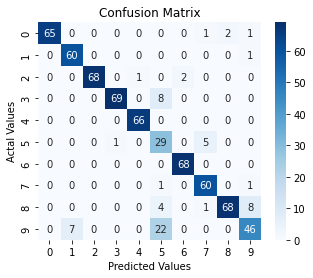

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
cm = confusion_matrix(y_hat, y_real)
cm_df = pd.DataFrame(cm)

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, cmap="Blues", annot=True)#, vmin=0, vmax=0.5
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()